# Silico true vs. sorted

In [3]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import spikeforest as sf
import os 
import pandas as pd
import spikeinterface as si
import warnings
import logging
import matplotlib
from pynwb import NWBHDF5IO
import spikeinterface.postprocessing as spost

# SET PROJECT PATH

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.study import spikestats
from src.nodes.postpro.npx_cell_types import get_interneurons
from src.nodes.postpro.allen_cell_types import load_session_data, load_all_sorted_spont_firing_rates, get_optotagged_neurons, get_spont_firing_rates
from src.nodes.postpro import waveform
from src.nodes.load import load_campaign_params

# SETUP EXPERIMENTS

# true silico
data_conf_silico_1, param_conf_silico_1 = get_config("silico_horvath", "probe_1").values()
RECORDING_PATH_SILICO_1 = data_conf_silico_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_1 = data_conf_silico_1["sorting"]["sorters"]["kilosort3"]["output"]
GT_PATH_SILICO_1 = data_conf_silico_1["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_FR_FILE_PATH_SILICO_1 = data_conf_silico_1["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_1 = data_conf_silico_1["postprocessing"]["sorted_neuron_metadata"]

data_conf_silico_2, param_conf_silico_2 = get_config("silico_horvath", "probe_2").values()
RECORDING_PATH_SILICO_2 = data_conf_silico_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_2 = data_conf_silico_2["sorting"]["sorters"]["kilosort3"]["output"]
GT_PATH_SILICO_2 = data_conf_silico_2["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_FR_FILE_PATH_SILICO_2 = data_conf_silico_2["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_2 = data_conf_silico_2["postprocessing"]["sorted_neuron_metadata"]

data_conf_silico_3, param_conf_silico_3 = get_config("silico_horvath", "probe_3").values()
RECORDING_PATH_SILICO_3 = data_conf_silico_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_3 = data_conf_silico_3["sorting"]["sorters"]["kilosort3"]["output"]
GT_PATH_SILICO_3 = data_conf_silico_3["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_FR_FILE_PATH_SILICO_3 = data_conf_silico_3["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_3 = data_conf_silico_3["postprocessing"]["sorted_neuron_metadata"]

# SETUP WAVEFORMS

MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

# SETUP WAVEFORMS

MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-11-02 14:38:36,353 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-02 14:38:36,366 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-02 14:38:36,367 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-02 14:38:36,381 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-02 14:38:36,381 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-02 14:38:36,395 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [4]:
def get_unit_firing_rates(data_conf, sorting_extractor_path, recording_path):
    """get layer-wise firing rates"""
    # get unit firing rates
    SortinTrue = si.load_extractor(sorting_extractor_path)
    firing_rates = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
        SortinTrue.unit_ids, recording_path, sorting_extractor_path, [], save=False
    )
    unit_rates = pd.DataFrame(
        data=np.array([SortinTrue.unit_ids, firing_rates]).T,
        columns=["unit_id", "firing_rate"],
    )
    unit_rates = dict()
    unit_rates["unit_id"] = np.array(SortinTrue.unit_ids)
    unit_rates["firing_rate"] = firing_rates

    # get unit layers
    unit_metadata = pd.DataFrame()
    simulation_params = load_campaign_params(data_conf)
    unit_metadata["layer"] = simulation_params["circuit"].cells.get(
        SortinTrue.unit_ids,
        properties=[
            "layer",
        ],
    )

    # standardize layers
    unit_metadata["layer"] = unit_metadata["layer"].apply(lambda x: "L" + x)

    # add unit ids
    unit_metadata.insert(loc=0, column="neuron", value=SortinTrue.unit_ids)
    return unit_rates, unit_metadata

### Compute

```bash
# sorted silico: run sequentially
sbatch --dependency=singleton --job-name=silico cluster/postpro/extract_waveform_silico_horvath_1.sbatch
sbatch --dependency=singleton --job-name=silico cluster/postpro/extract_waveform_silico_horvath_2.sbatch
sbatch --dependency=singleton --job-name=silico cluster/postpro/extract_waveform_silico_horvath_3.sbatch
sbatch --dependency=singleton --job-name=silico cluster/postpro/get_silico_horvath_sorted_units_metadata.sbatch
```

In [6]:
# TRUE -----

# get unit firing rates and layers by depth
unit_fr_1, unit_metadata_1 = get_unit_firing_rates(
    data_conf_silico_1, GT_PATH_SILICO_1, RECORDING_PATH_SILICO_1
)
unit_fr_2, unit_metadata_2 = get_unit_firing_rates(
    data_conf_silico_2, GT_PATH_SILICO_2, RECORDING_PATH_SILICO_2
)
unit_fr_3, unit_metadata_3 = get_unit_firing_rates(
    data_conf_silico_3, GT_PATH_SILICO_3, RECORDING_PATH_SILICO_3
)

# get all layer-wise firing rates
(
    fr_layer_1,
    fr_layer_2_3,
    fr_layer_4,
    fr_layer_5,
    fr_layer_6,
    fr_outside,
) = spikestats.get_layerwise_fr_all_depths(
    unit_fr_1, unit_fr_2, unit_fr_3, unit_metadata_1, unit_metadata_2, unit_metadata_3
)

# SORTED -----

sorted_fr_1 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_silico_1,
    RECORDING_PATH_SILICO_1,
    SORTED_PATH_SILICO_1,
    SORTED_FR_FILE_PATH_SILICO_1,
    save=True,
)
sorted_fr_2 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_silico_2,
    RECORDING_PATH_SILICO_2,
    SORTED_PATH_SILICO_2,
    SORTED_FR_FILE_PATH_SILICO_2,
    save=True,
)
sorted_fr_3 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_silico_3,
    RECORDING_PATH_SILICO_3,
    SORTED_PATH_SILICO_3,
    SORTED_FR_FILE_PATH_SILICO_3,
    save=True,
)

# get unit firing rates and layers metadata by depth
sorted_metadata_1 = pd.read_csv(SILICO_SORTED_METADATA_FILE_1)
sorted_metadata_2 = pd.read_csv(SILICO_SORTED_METADATA_FILE_2)
sorted_metadata_3 = pd.read_csv(SILICO_SORTED_METADATA_FILE_3)

# get all layer-wise firing rates
(
    sorted_fr_layer_1,
    sorted_fr_layer_2_3,
    sorted_fr_layer_4,
    sorted_fr_layer_5,
    sorted_fr_layer_6,
    sorted_fr_outside,
) = spikestats.get_layerwise_fr_all_depths(
    sorted_fr_1,
    sorted_fr_2,
    sorted_fr_3,
    sorted_metadata_1,
    sorted_metadata_2,
    sorted_metadata_3,
)

/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/firing_rate/lib/python3.9/site-packages/spikeinterface/core/base.py:998: UserWarning: Versions are not the same. This might lead compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/firing_rate/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/firing_rate/lib/python3.9/site-packages/spikeinterface/core/base.py:998: UserWarning: Versions are not the same. This might lead compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/firing_rate/lib/python

### Plot

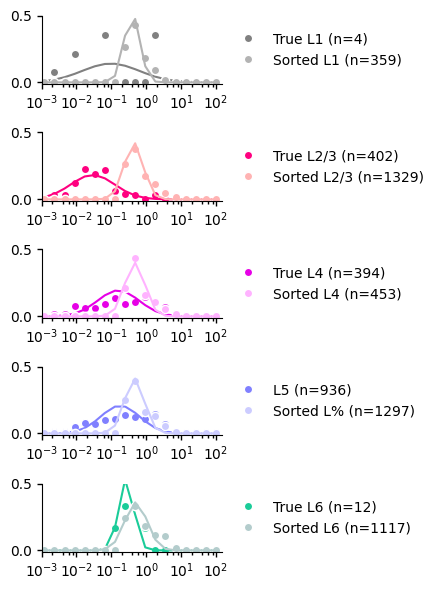

In [17]:
MARKERSIZE = 6
Y_MAX = 0.5

fig, axes = plt.subplots(5, 1, figsize=(4.5, 6))

# L1
spikestats.plot_firing_rate_hist_ground_truths(
    fr_layer_1,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"True L1 (n={len(fr_layer_1)})",
    color=(0.5, 0.5, 0.5),
    markerfacecolor=(0.5, 0.5, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_fr_layer_1,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"Sorted L1 (n={len(sorted_fr_layer_1)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].set_ylim([-0.01, Y_MAX])

# L2/3
spikestats.plot_firing_rate_hist_ground_truths(
    fr_layer_2_3,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"True L2/3 (n={len(fr_layer_2_3)})",
    color=(1, 0, 0.5),
    markerfacecolor=(1, 0, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_fr_layer_2_3,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"Sorted L2/3 (n={len(sorted_fr_layer_2_3)})",
    color=(1, 0.7, 0.7),
    markerfacecolor=(1, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[1].set_ylim([-0.01, Y_MAX])
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L4 -----
spikestats.plot_firing_rate_hist_ground_truths(
    fr_layer_4,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"True L4 (n={len(fr_layer_4)})",
    color=(0.9, 0, 0.9),
    markerfacecolor=(0.9, 0, 0.9),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_fr_layer_4,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"Sorted L4 (n={len(sorted_fr_layer_4)})",
    color=(1, 0.7, 1),
    markerfacecolor=(1, 0.7, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[2].set_ylim([-0.01, Y_MAX])
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L5
spikestats.plot_firing_rate_hist_ground_truths(
    fr_layer_5,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"L5 (n={len(fr_layer_5)})",
    color=(0.5, 0.5, 1),
    markerfacecolor=(0.5, 0.5, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_fr_layer_5,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"Sorted L% (n={len(sorted_fr_layer_5)})",
    color=(0.8, 0.8, 1),
    markerfacecolor=(0.8, 0.8, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[3].set_ylim([-0.01, Y_MAX])
axes[3].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L6
spikestats.plot_firing_rate_hist_ground_truths(
    fr_layer_6,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"True L6 (n={len(fr_layer_6)})",
    color=(0.1, 0.8, 0.6),
    markerfacecolor=(0.1, 0.8, 0.6),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_fr_layer_6,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"Sorted L6 (n={len(sorted_fr_layer_6)})",
    color=(0.7, 0.8, 0.8),
    markerfacecolor=(0.7, 0.8, 0.8),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[4].set_ylim([-0.01, Y_MAX])
axes[4].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()